/tmp/ipython-input-199036930.py:181: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data_t['ano'], rotation=90, size=8)
/tmp/ipython-input-199036930.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['{:,.0f}k'.format(x/1000) for x in vals], size=8, color='red')
/tmp/ipython-input-199036930.py:181: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(data_t['ano'], rotation=90, size=8)
/tmp/ipython-input-199036930.py:191: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['{:,.0f}k'.format(x/1000) for x in vals], size=8, color='red')
/tmp/ipython-input-199036930.py:181: UserWarning: set_

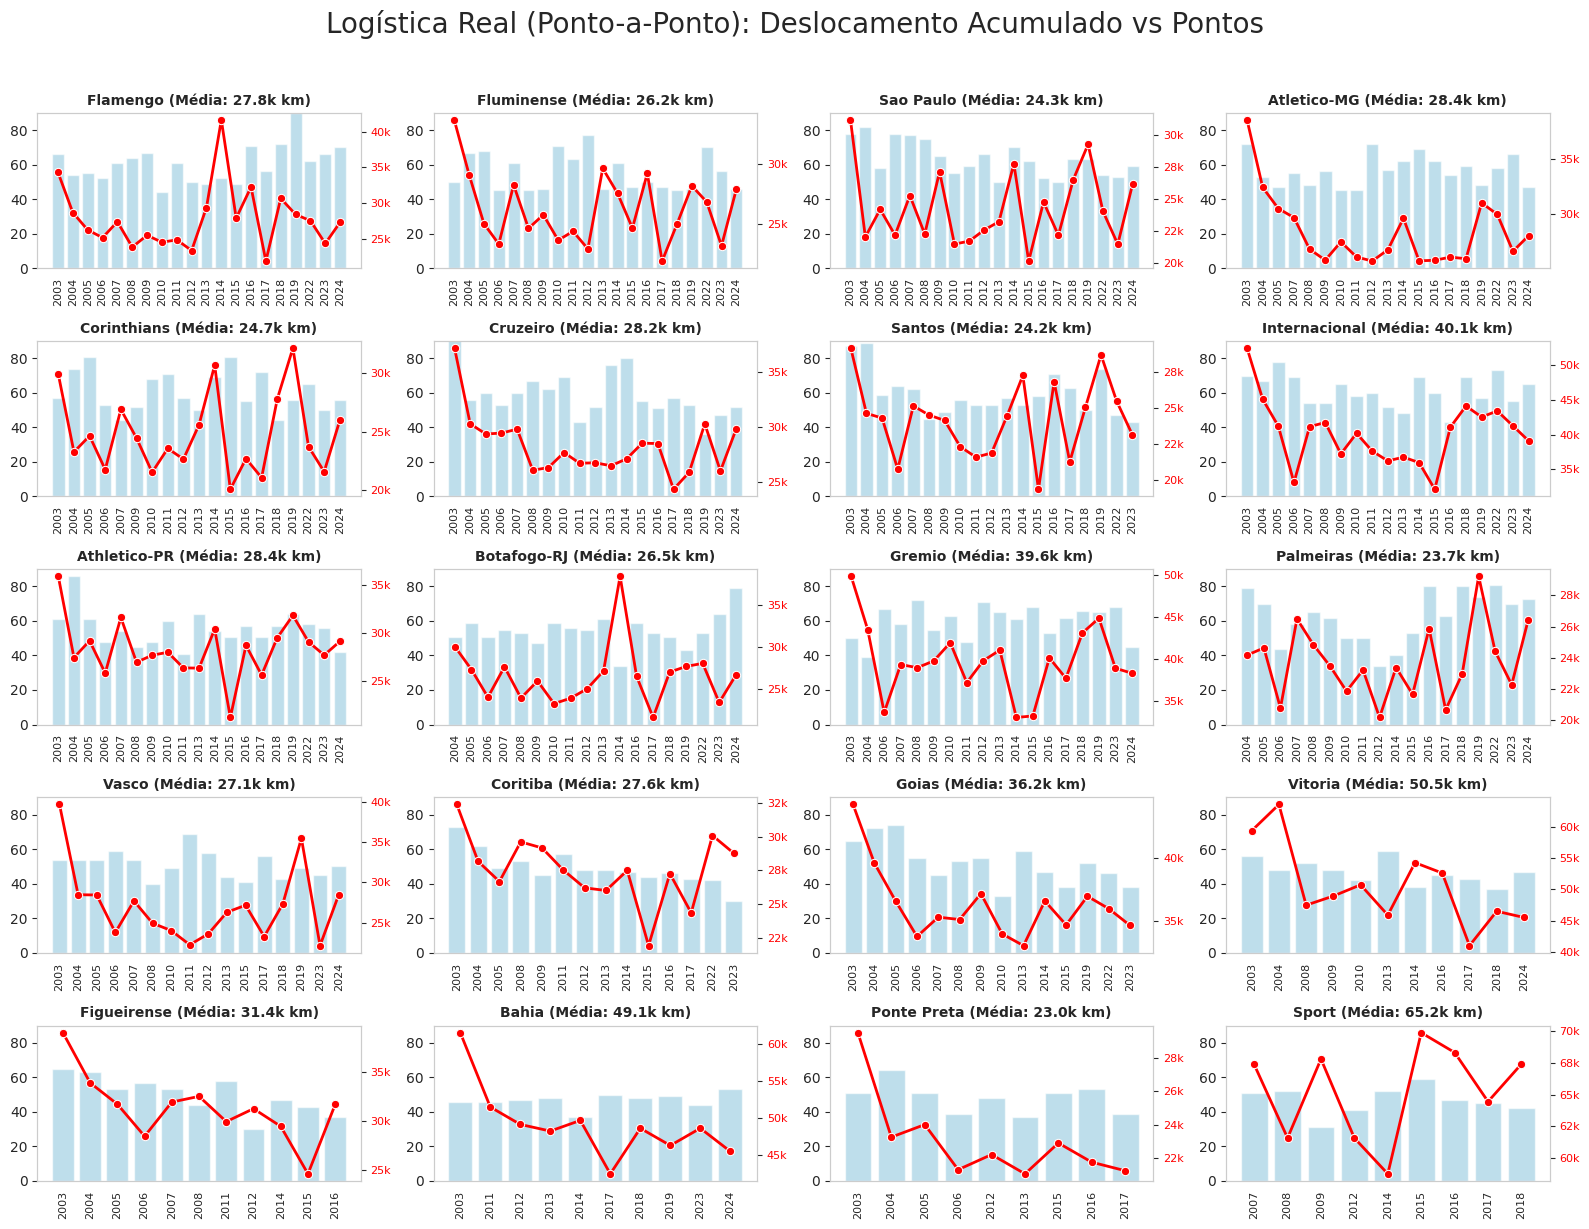


--- TOP 10 MÉDIA DE KM POR ANO (Modelo Ponto-a-Ponto) ---
time
Paysandu      95,472 km
America-RN    74,527 km
Fortaleza     73,630 km
Ceara         73,532 km
Sport         65,232 km
Nautico       64,940 km
Santa Cruz    62,714 km
CSA           50,533 km
Vitoria       50,520 km
Bahia         49,094 km
Name: km_total, dtype: object


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
import math

# --- 1. CARREGAMENTO E PREPARAÇÃO ---

df_matches = pd.read_csv('data2.csv')
df_arenas = pd.read_csv('arena_coords.csv')
df_estados = pd.read_csv('estado_coords.csv')

# Conversão de Datas
df_matches['data'] = pd.to_datetime(df_matches['data'], dayfirst=True, errors='coerce')
df_matches['ano'] = df_matches['data'].dt.year

# Filtro de Anos (Excluindo 2020/2021)
anos_range = list(range(2003, 2025))
anos_excluir = [2020, 2021]
anos_foco = [ano for ano in anos_range if ano not in anos_excluir]
df_matches = df_matches[df_matches['ano'].isin(anos_foco)].copy()

# Padronização de strings para evitar erros de chave
df_matches['arena_clean'] = df_matches['arena'].astype(str).str.lower().str.strip()
df_arenas['estadio_original'] = df_arenas['estadio_original'].astype(str).str.lower().str.strip()

# Criar Dicionários de Coordenadas (Hash Maps para velocidade)
arena_lat = dict(zip(df_arenas['estadio_original'], df_arenas['latitude']))
arena_lon = dict(zip(df_arenas['estadio_original'], df_arenas['longitude']))
estado_lat = dict(zip(df_estados['estado'], df_estados['latitude']))
estado_lon = dict(zip(df_estados['estado'], df_estados['longitude']))

# --- 2. CONSTRUÇÃO DA TRAJETÓRIA (ALGORITMO DE ROTA) ---

# Passo A: Transformar o dataframe de "Jogos" em uma "Linha do Tempo de Movimentação"
# Precisamos duplicar os registros: uma entrada para o mandante, uma para o visitante

def get_coords_jogo(row):
    # Tenta pegar a arena, se falhar, pega o estado do mandante
    lat = arena_lat.get(row['arena_clean'])
    lon = arena_lon.get(row['arena_clean'])

    if lat is None or np.isnan(lat):
        lat = estado_lat.get(row['mandante_Estado'])
        lon = estado_lon.get(row['mandante_Estado'])

    return lat, lon

# Aplicar coordenadas do jogo
coords = df_matches.apply(get_coords_jogo, axis=1, result_type='expand')
df_matches['lat_jogo'] = coords[0]
df_matches['lon_jogo'] = coords[1]

# Criar lista de eventos
movimentacoes = []

for idx, row in df_matches.iterrows():
    # Registro do Mandante (Ele "vai" para o estádio do jogo, mesmo que seja o dele)
    movimentacoes.append({
        'ano': row['ano'],
        'data': row['data'],
        'time': row['mandante'],
        'estado_base': row['mandante_Estado'],
        'lat': row['lat_jogo'],
        'lon': row['lon_jogo'],
        'tipo': 'jogo'
    })
    # Registro do Visitante
    movimentacoes.append({
        'ano': row['ano'],
        'data': row['data'],
        'time': row['visitante'],
        'estado_base': row['visitante_Estado'], # Base do time
        'lat': row['lat_jogo'], # Local do jogo
        'lon': row['lon_jogo'],
        'tipo': 'jogo'
    })

df_rota = pd.DataFrame(movimentacoes)

# Passo B: Adicionar "Ponto Zero" (Início da Temporada na Sede) e "Retorno Final"
# Para cada Time e Ano, o time começa na sede e termina na sede.
registros_base = []
times_ano = df_rota[['ano', 'time', 'estado_base']].drop_duplicates()

for idx, row in times_ano.iterrows():
    lat_base = estado_lat.get(row['estado_base'])
    lon_base = estado_lon.get(row['estado_base'])

    if lat_base is None: continue

    # Início da temporada (Data fictícia: 1 de Jan)
    registros_base.append({
        'ano': row['ano'],
        'data': pd.Timestamp(f"{row['ano']}-01-01"),
        'time': row['time'],
        'estado_base': row['estado_base'],
        'lat': lat_base,
        'lon': lon_base,
        'tipo': 'inicio'
    })

    # Fim da temporada (Data fictícia: 31 de Dez) - Garante o cálculo da volta pra casa
    registros_base.append({
        'ano': row['ano'],
        'data': pd.Timestamp(f"{row['ano']}-12-31"),
        'time': row['time'],
        'estado_base': row['estado_base'],
        'lat': lat_base,
        'lon': lon_base,
        'tipo': 'fim'
    })

df_rota = pd.concat([df_rota, pd.DataFrame(registros_base)])

# Passo C: Ordenar Cronologicamente
df_rota = df_rota.sort_values(['time', 'data'])

# Passo D: Calcular Distância Ponto a Ponto (Shift)
# Agrupamos por time e ano para garantir que não calculamos distância entre 2018 e 2019
df_rota['lat_prev'] = df_rota.groupby(['time', 'ano'])['lat'].shift(1)
df_rota['lon_prev'] = df_rota.groupby(['time', 'ano'])['lon'].shift(1)

# Função vetorizada não funciona bem com geopy, vamos usar list comprehension (rápido o suficiente)
def calc_dist(row):
    if pd.isna(row['lat_prev']) or pd.isna(row['lat']):
        return 0.0
    # Se a coordenada não mudou (Jogou em casa e depois jogou em casa dnv), distância é 0
    if row['lat'] == row['lat_prev'] and row['lon'] == row['lon_prev']:
        return 0.0
    return geodesic((row['lat_prev'], row['lon_prev']), (row['lat'], row['lon'])).km

# Calcular apenas onde temos dados válidos
mask_valid = df_rota['lat_prev'].notnull()
df_rota.loc[mask_valid, 'distancia_trecho'] = df_rota[mask_valid].apply(calc_dist, axis=1)
df_rota['distancia_trecho'] = df_rota['distancia_trecho'].fillna(0)

# --- 3. AGREGAÇÃO E RESULTADOS ---

# Somar KM total por ano
df_km_real = df_rota.groupby(['ano', 'time'])['distancia_trecho'].sum().reset_index()
df_km_real = df_km_real.rename(columns={'distancia_trecho': 'km_total'})

# Recalcular Pontos (para o gráfico)
def get_pontos_simples(row):
    if row['vencedor'] == row['mandante']: return 3, 0
    elif row['vencedor'] == row['visitante']: return 0, 3
    else: return 1, 1

pts = df_matches.apply(get_pontos_simples, axis=1, result_type='expand')
df_matches['pts_man'] = pts[0]
df_matches['pts_vis'] = pts[1]

df_pts = pd.concat([
    df_matches[['ano', 'mandante', 'pts_man']].rename(columns={'mandante':'time', 'pts_man':'pontos'}),
    df_matches[['ano', 'visitante', 'pts_vis']].rename(columns={'visitante':'time', 'pts_vis':'pontos'})
]).groupby(['ano', 'time']).sum().reset_index()

# Juntar tudo
df_final_real = pd.merge(df_km_real, df_pts, on=['ano', 'time'])

# --- 4. VISUALIZAÇÃO COM DADOS CORRIGIDOS ---

# Selecionar Top 20 times mais frequentes para não quebrar o gráfico
top_times = df_final_real['time'].value_counts().head(20).index
df_plot = df_final_real[df_final_real['time'].isin(top_times)].copy()

plt.figure(figsize=(16, 12))
n_cols = 4
n_rows = math.ceil(len(top_times) / n_cols)

for i, time in enumerate(top_times):
    ax = plt.subplot(n_rows, n_cols, i+1)
    data_t = df_plot[df_plot['time'] == time].sort_values('ano')

    # Barras de Pontos
    sns.barplot(data=data_t, x='ano', y='pontos', color='skyblue', alpha=0.6, ax=ax)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticklabels(data_t['ano'], rotation=90, size=8)
    ax.set_ylim(0, 90) # Escala fixa para pontos

    # Linha de KM
    ax2 = ax.twinx()
    sns.lineplot(data=data_t, x=ax.get_xticks(), y='km_total', color='red', marker='o', ax=ax2, linewidth=2)

    # Formatação Eixo KM
    ax2.set_ylabel('')
    vals = ax2.get_yticks()
    ax2.set_yticklabels(['{:,.0f}k'.format(x/1000) for x in vals], size=8, color='red')

    media_km = data_t['km_total'].mean()
    ax.set_title(f"{time} (Média: {media_km/1000:.1f}k km)", fontsize=10, fontweight='bold')

    # Remover grids excessivos
    ax.grid(False)
    ax2.grid(False)

plt.suptitle('Logística Real (Ponto-a-Ponto): Deslocamento Acumulado vs Pontos', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

# --- 5. TABELA COMPARATIVA: QUEM VIAJA MAIS NO NOVO MODELO? ---
ranking = df_final_real.groupby('time')['km_total'].mean().sort_values(ascending=False).head(10)
print("\n--- TOP 10 MÉDIA DE KM POR ANO (Modelo Ponto-a-Ponto) ---")
print(ranking.apply(lambda x: f"{x:,.0f} km"))

/tmp/ipython-input-1069244636.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,.0f}k'.format(x/1000) for x in vals])


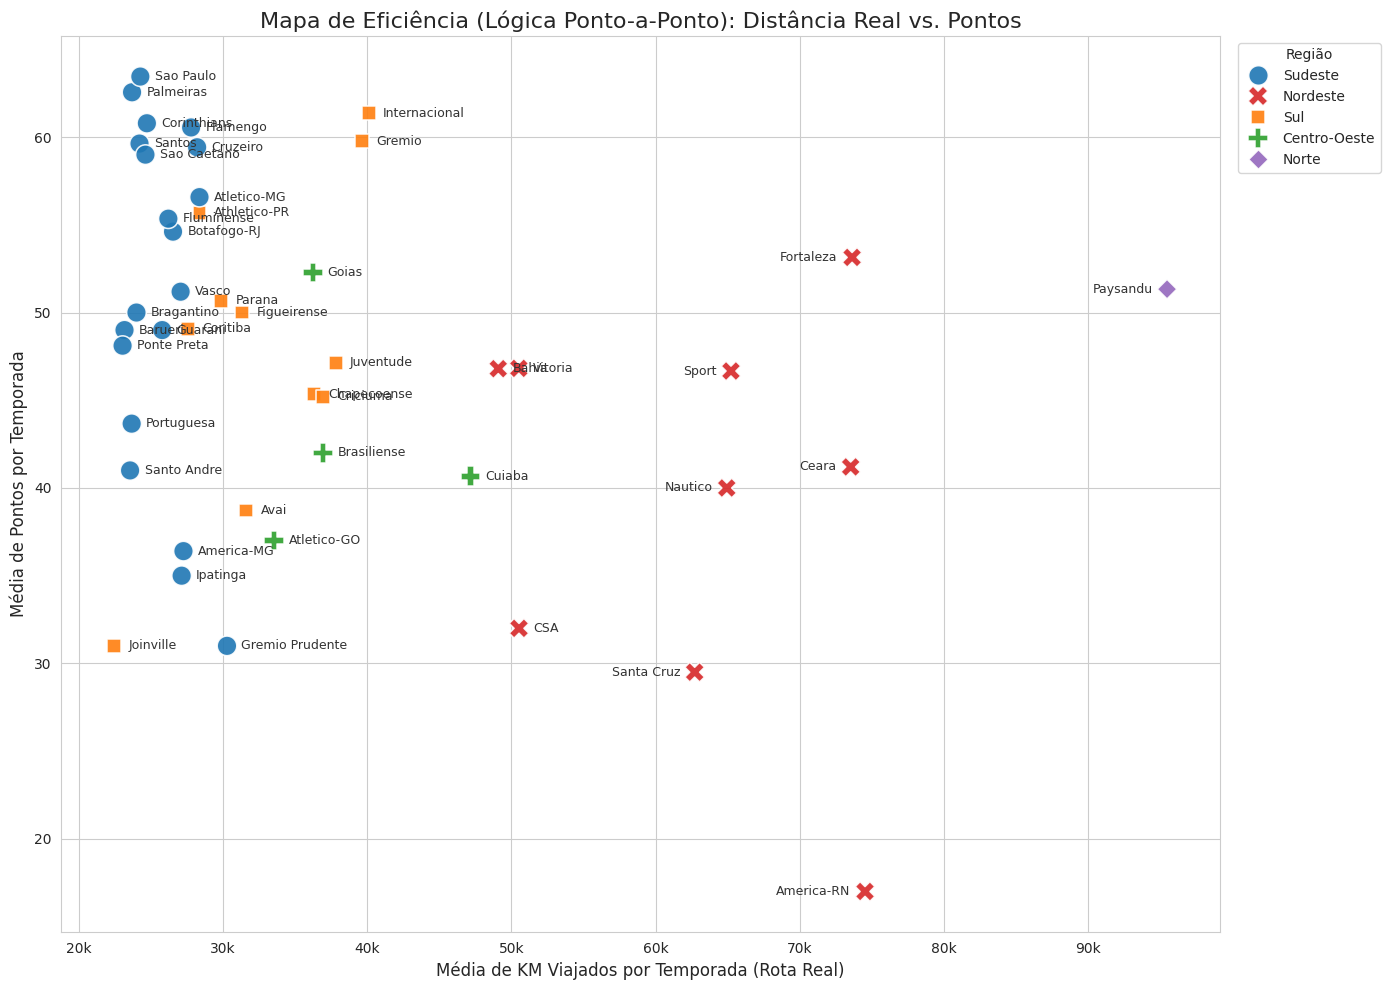

In [ ]:
# 1. PREPARAÇÃO DOS DADOS (Usando df_final_real que tem o cálculo cronológico)
# Dicionário mapeando UF -> Região
mapa_regioes = {
    'RS': 'Sul', 'SC': 'Sul', 'PR': 'Sul',
    'SP': 'Sudeste', 'RJ': 'Sudeste', 'MG': 'Sudeste', 'ES': 'Sudeste',
    'MT': 'Centro-Oeste', 'MS': 'Centro-Oeste', 'GO': 'Centro-Oeste', 'DF': 'Centro-Oeste',
    'BA': 'Nordeste', 'CE': 'Nordeste', 'PE': 'Nordeste', 'AL': 'Nordeste',
    'RN': 'Nordeste', 'SE': 'Nordeste', 'PB': 'Nordeste', 'MA': 'Nordeste', 'PI': 'Nordeste',
    'PA': 'Norte', 'AM': 'Norte'
}

# Tabela de referência Time -> Estado
ref_time_estado = df_matches[['mandante', 'mandante_Estado']].drop_duplicates('mandante').set_index('mandante')

# Calcular médias usando df_final_real e km_total
df_medio = df_final_real.groupby('time')[['pontos', 'km_total']].mean().reset_index()

# Adicionar metadados
df_medio['estado'] = df_medio['time'].map(ref_time_estado['mandante_Estado'])
df_medio['regiao'] = df_medio['estado'].map(mapa_regioes)

# --- GRÁFICO 1: SCATTER PLOT (Eficácia x Distância Real) ---
plt.figure(figsize=(14, 10))
sns.set_style("whitegrid")

cores_regiao = {
    'Sudeste': '#1f77b4', 'Sul': '#ff7f0e',
    'Nordeste': '#d62728', 'Centro-Oeste': '#2ca02c', 'Norte': '#9467bd'
}

sns.scatterplot(
    data=df_medio,
    x='km_total',   # <--- AQUI MUDOU (km_total é o cálculo correto)
    y='pontos',
    hue='regiao',
    style='regiao',
    palette=cores_regiao,
    s=200, alpha=0.9
)

# Adicionar nomes
for i in range(df_medio.shape[0]):
    row = df_medio.iloc[i]
    # Ajuste de posição do texto
    offset_x = 1000 if row.km_total < 60000 else -1000
    align = 'left' if row.km_total < 60000 else 'right'

    plt.text(row.km_total + offset_x, row.pontos, row.time,
             fontsize=9, ha=align, va='center', color='#333333')

plt.title('Mapa de Eficiência (Lógica Ponto-a-Ponto): Distância Real vs. Pontos', fontsize=16)
plt.xlabel('Média de KM Viajados por Temporada (Rota Real)', fontsize=12)
plt.ylabel('Média de Pontos por Temporada', fontsize=12)
plt.legend(title='Região', bbox_to_anchor=(1.01, 1), loc='upper left')

# Formatar eixo X para "50k"
ax = plt.gca()
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.0f}k'.format(x/1000) for x in vals])

plt.tight_layout()
plt.show()

/tmp/ipython-input-3767563158.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-3767563158.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0f}k'.format(x/1000) for x in vals])


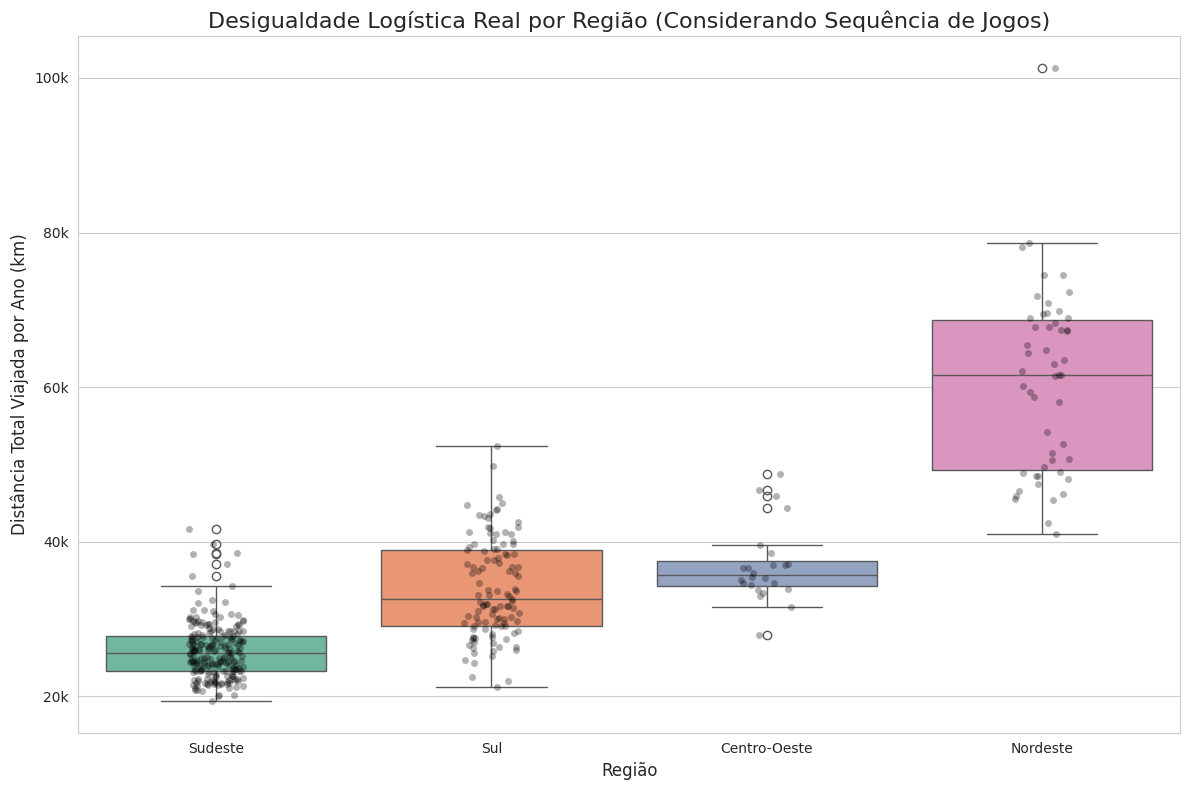

In [ ]:
# Adicionar região ao df_final_real para o boxplot usar todos os anos
df_final_real['estado'] = df_final_real['time'].map(ref_time_estado['mandante_Estado'])
df_final_real['regiao'] = df_final_real['estado'].map(mapa_regioes)

plt.figure(figsize=(12, 8))
sns.boxplot(
    data=df_final_real,
    x='regiao',
    y='km_total',  # <--- USANDO A COLUNA CORRETA
    palette='Set2',
    order=['Sudeste', 'Sul', 'Centro-Oeste', 'Nordeste']
)

sns.stripplot(data=df_final_real, x='regiao', y='km_total', color='black', alpha=0.3, jitter=True, order=['Sudeste', 'Sul', 'Centro-Oeste', 'Nordeste'])

plt.title('Desigualdade Logística Real por Região (Considerando Sequência de Jogos)', fontsize=16)
plt.ylabel('Distância Total Viajada por Ano (km)', fontsize=12)
plt.xlabel('Região', fontsize=12)

# Formatar eixo Y
ax = plt.gca()
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0f}k'.format(x/1000) for x in vals])

plt.tight_layout()
plt.show()

/tmp/ipython-input-4136700285.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analise_jetlag = df_jogos_rota.groupby('categoria_distancia').agg(
/tmp/ipython-input-4136700285.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=analise_jetlag, x='categoria_distancia', y='aproveitamento', palette=colors)


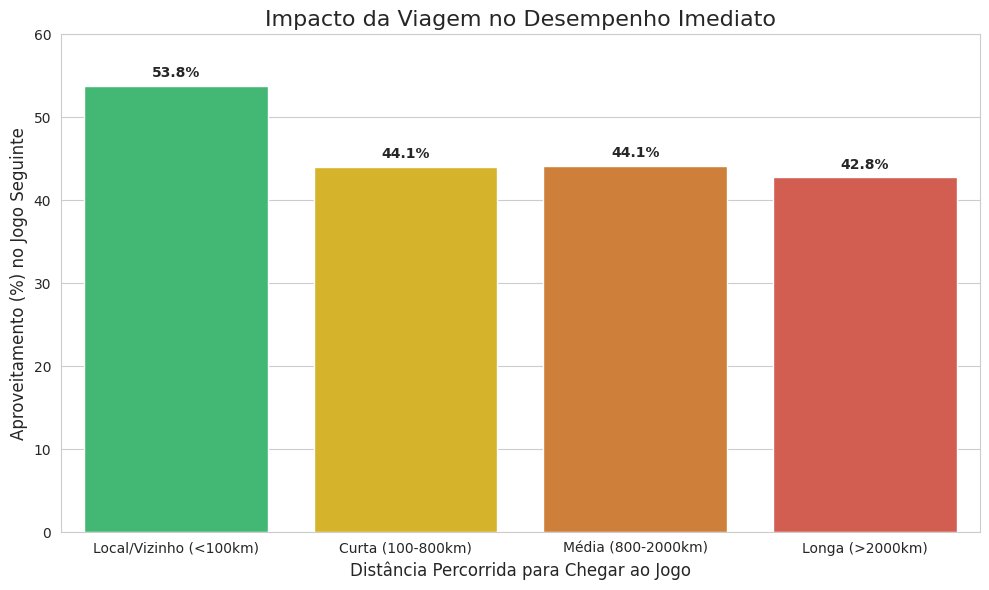

In [ ]:
# --- CÉLULA 2: Efeito Jet-Lag (Desempenho Pós-Viagem) ---

# 1. Cruzar a rota (que tem a distância) com o resultado do jogo
# Precisamos saber se o time ganhou o jogo daquela viagem específica
df_jogos_rota = df_rota[df_rota['tipo'] == 'jogo'].copy()

# Função auxiliar para pegar pontos ganhos no jogo específico
def get_pts_jogo(row):
    # Procura o jogo no df_matches original
    match = df_matches[
        (df_matches['data'] == row['data']) &
        ((df_matches['mandante'] == row['time']) | (df_matches['visitante'] == row['time']))
    ]
    if match.empty: return np.nan

    match = match.iloc[0]
    is_mandante = (match['mandante'] == row['time'])

    # Lógica de pontos
    if match['vencedor'] == row['time']: return 3
    elif match['vencedor'] == '-': return 1
    else: return 0

df_jogos_rota['pontos_jogo'] = df_jogos_rota.apply(get_pts_jogo, axis=1)
df_jogos_rota = df_jogos_rota.dropna(subset=['pontos_jogo']) # Remove erros de merge

# 2. Categorizar a Distância da Viagem
bins = [-1, 100, 800, 2000, 10000]
labels = ['Local/Vizinho (<100km)', 'Curta (100-800km)', 'Média (800-2000km)', 'Longa (>2000km)']
df_jogos_rota['categoria_distancia'] = pd.cut(df_jogos_rota['distancia_trecho'], bins=bins, labels=labels)

# 3. Calcular Aproveitamento por Categoria
# Aproveitamento = (Pontos Ganhos / (Jogos * 3)) * 100
analise_jetlag = df_jogos_rota.groupby('categoria_distancia').agg(
    jogos=('time', 'count'),
    pontos_ganhos=('pontos_jogo', 'sum')
).reset_index()

analise_jetlag['aproveitamento'] = (analise_jetlag['pontos_ganhos'] / (analise_jetlag['jogos'] * 3)) * 100

# 4. Visualização
plt.figure(figsize=(10, 6))
colors = ['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'] # Verde -> Vermelho

ax = sns.barplot(data=analise_jetlag, x='categoria_distancia', y='aproveitamento', palette=colors)

plt.title('Impacto da Viagem no Desempenho Imediato', fontsize=16)
plt.ylabel('Aproveitamento (%) no Jogo Seguinte', fontsize=12)
plt.xlabel('Distância Percorrida para Chegar ao Jogo', fontsize=12)
plt.ylim(0, 60) # Ajuste conforme necessário

# Colocar valores nas barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontweight='bold')

plt.tight_layout()
plt.show()

/tmp/ipython-input-3981782250.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_validos['distancia_visitante'] = pd.cut(df_validos['distancia_trecho'], bins=bins, labels=labels)
/tmp/ipython-input-3981782250.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analise_arma = df_validos.groupby('distancia_visitante')['mandante_ganhou'].mean().reset_index()
/tmp/ipython-input-3981782250.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` fo

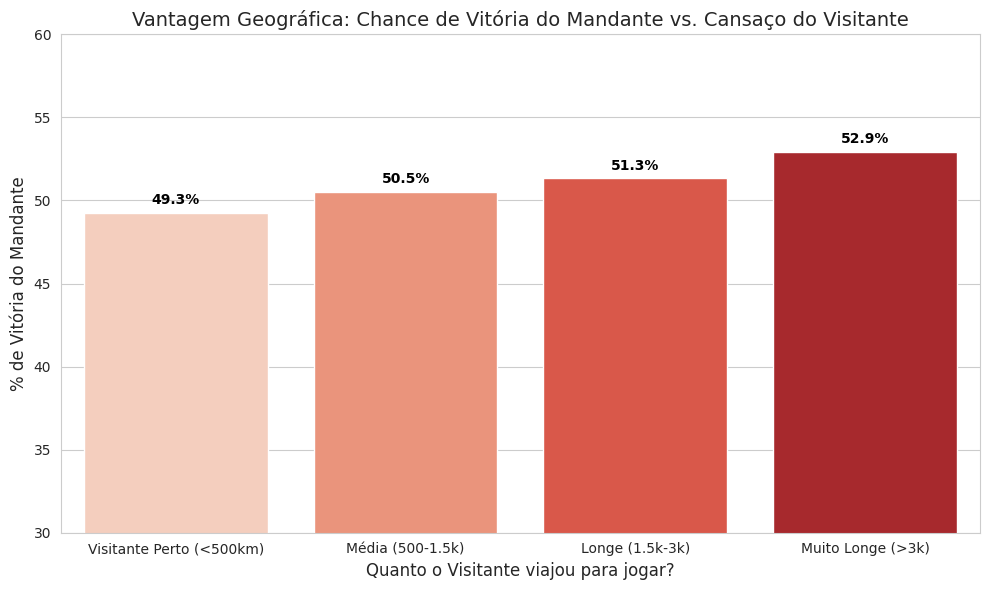

In [ ]:
# --- ANÁLISE 2: A GEOGRAFIA COMO ARMA (Cansaço do Visitante) ---

# Precisamos saber a distância percorrida pelo VISITANTE para chegar ao jogo
# Já calculamos isso na variável `distancia_trecho` do df_rota, mas precisamos cruzar com o jogo

# Filtrar apenas as rotas que são jogos e são visitantes
# Nota: No df_rota, temos registros duplicados (mandante e visitante).
# Queremos saber quanto o VISITANTE andou para chegar na casa do MANDANTE.

df_visitantes = df_rota[(df_rota['tipo'] == 'jogo')].copy()
# Vamos simplificar: Pegar a distância do trecho anterior.
# Se o registro é do "Flamengo" jogando contra o "Bahia" na Fonte Nova, a distancia_trecho do Flamengo é o que conta.

# Cruzar com resultado do jogo
def check_win_mandante(row):
    match = df_matches[(df_matches['data'] == row['data']) &
                       (df_matches['visitante'] == row['time'])]
    if match.empty: return np.nan
    vencedor = match.iloc[0]['vencedor']
    mandante = match.iloc[0]['mandante']

    return 1 if vencedor == mandante else 0

# Essa operação pode ser lenta, vamos fazer amostra ou otimizar se precisar
# Para ser rápido, vamos agregar por faixas
df_visitantes['mandante_ganhou'] = df_visitantes.apply(check_win_mandante, axis=1)
df_validos = df_visitantes.dropna(subset=['mandante_ganhou'])

# Criar faixas de distância que o visitante percorreu
bins = [0, 500, 1500, 3000, 10000]
labels = ['Visitante Perto (<500km)', 'Média (500-1.5k)', 'Longe (1.5k-3k)', 'Muito Longe (>3k)']
df_validos['distancia_visitante'] = pd.cut(df_validos['distancia_trecho'], bins=bins, labels=labels)

# Calcular % de vitória do Mandante por faixa de distância do Visitante
analise_arma = df_validos.groupby('distancia_visitante')['mandante_ganhou'].mean().reset_index()
analise_arma['win_rate'] = analise_arma['mandante_ganhou'] * 100

# Visualização 2
plt.figure(figsize=(10, 6))
sns.barplot(data=analise_arma, x='distancia_visitante', y='win_rate', palette="Reds")

plt.title('Vantagem Geográfica: Chance de Vitória do Mandante vs. Cansaço do Visitante', fontsize=14)
plt.ylabel('% de Vitória do Mandante', fontsize=12)
plt.xlabel('Quanto o Visitante viajou para jogar?', fontsize=12)
plt.ylim(30, 60) # Ajuste para destacar a diferença

for index, row in analise_arma.iterrows():
    plt.text(index, row.win_rate + 0.5, f"{row.win_rate:.1f}%", color='black', ha="center", fontweight='bold')

plt.tight_layout()
plt.show()

/tmp/ipython-input-3412963863.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0f}k'.format(x/1000) for x in vals])


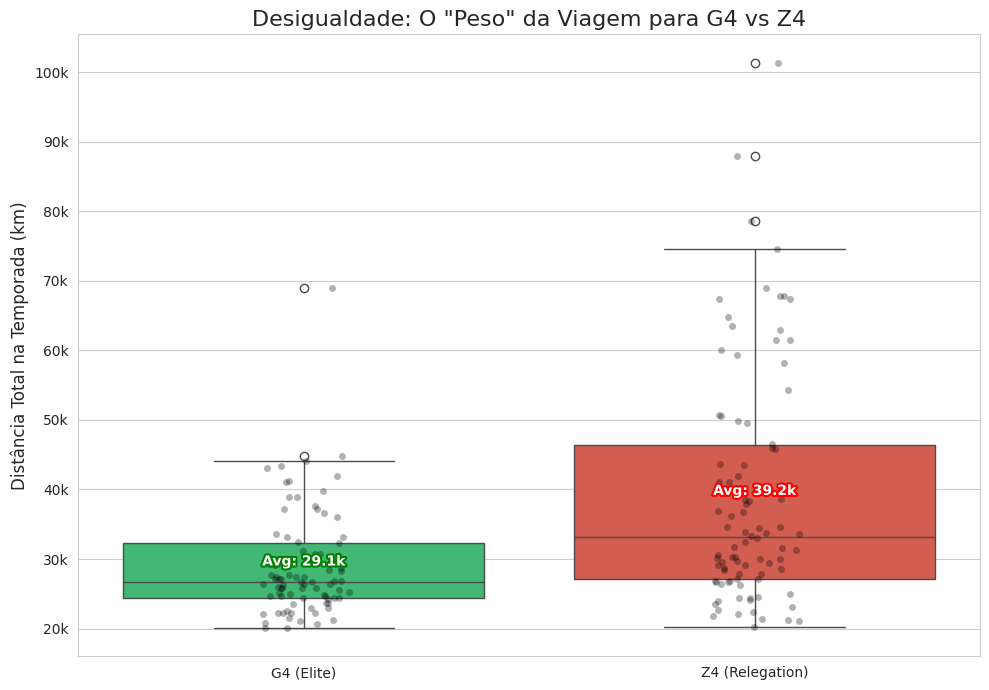

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as PathEffects # Correct import

# --- ANALYSIS 2: IMPACT ON TABLE (G4 vs Z4) ---

# 1. Calculate final ranking for each year
# (Note: We simplify using points. Real criteria has wins, goal diff, etc., but works for macro analysis)
df_final_real['rank'] = df_final_real.groupby('ano')['pontos'].rank(method='first', ascending=False)

def classificar_grupo(row):
    if row['rank'] <= 4:
        return 'G4 (Elite)'
    elif row['rank'] >= 17:
        return 'Z4 (Relegation)'
    else:
        return 'Mid-Table'

df_final_real['grupo'] = df_final_real.apply(classificar_grupo, axis=1)

# Filter only extremes
df_extremos = df_final_real[df_final_real['grupo'] != 'Mid-Table'].copy()

# Visualization
plt.figure(figsize=(10, 7))

# Fix: Added 'hue' to avoid FutureWarning. Removed 'legend=False' which caused TypeError in some versions.
sns.boxplot(
    data=df_extremos,
    x='grupo',
    y='km_total',
    hue='grupo',
    palette={'G4 (Elite)': '#2ecc71', 'Z4 (Relegation)': '#e74c3c'},
    order=['G4 (Elite)', 'Z4 (Relegation)']
)

# Add individual points to see outliers
sns.stripplot(
    data=df_extremos,
    x='grupo',
    y='km_total',
    color='black',
    alpha=0.3,
    jitter=True,
    order=['G4 (Elite)', 'Z4 (Relegation)']
)

plt.title('Desigualdade: O "Peso" da Viagem para G4 vs Z4', fontsize=16)
plt.ylabel('Distância Total na Temporada (km)', fontsize=12)
plt.xlabel('')

# Quick statistical text (Difference of means)
g4_mean = df_extremos[df_extremos['grupo']=='G4 (Elite)']['km_total'].mean()
z4_mean = df_extremos[df_extremos['grupo']=='Z4 (Relegation)']['km_total'].mean()

# Fix: Correct use of PathEffects
plt.text(0, g4_mean, f"Avg: {g4_mean/1000:.1f}k", ha='center', color='white', fontweight='bold',
         path_effects=[PathEffects.withStroke(linewidth=3, foreground='green')])
plt.text(1, z4_mean, f"Avg: {z4_mean/1000:.1f}k", ha='center', color='white', fontweight='bold',
         path_effects=[PathEffects.withStroke(linewidth=3, foreground='red')])

ax = plt.gca()
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0f}k'.format(x/1000) for x in vals])

plt.tight_layout()
plt.show()

/tmp/ipython-input-1311571750.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=analise_matrix, x='cenario', y='aproveitamento', order=ordem, palette="RdYlGn_r")


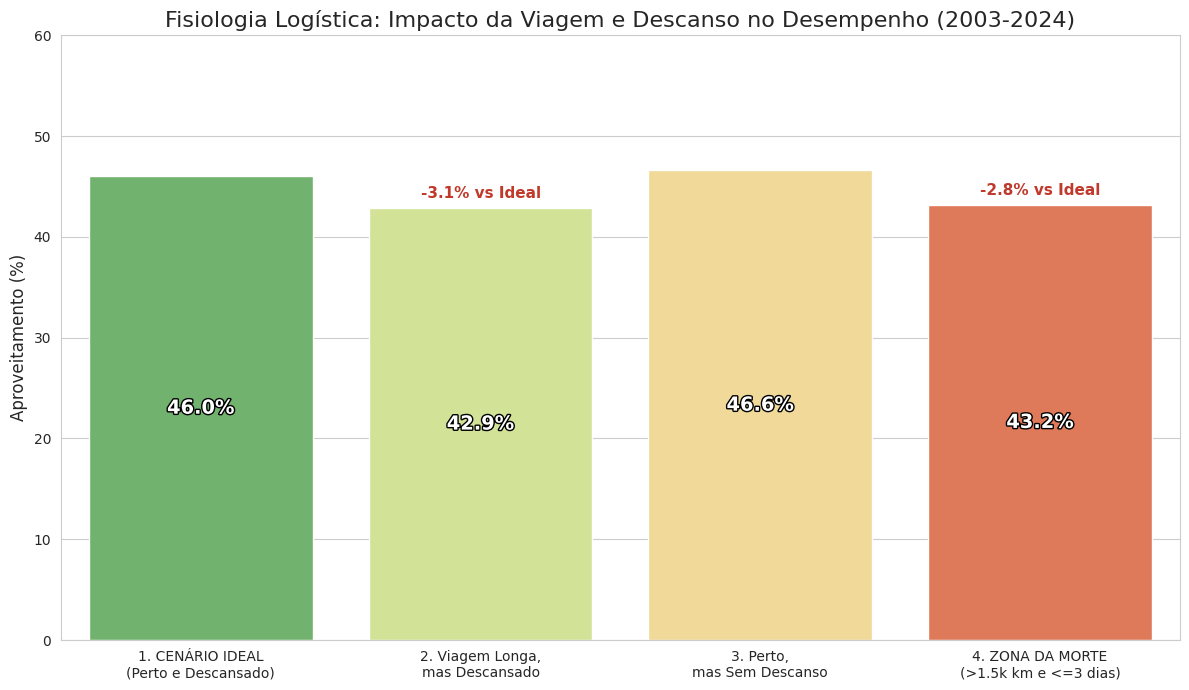

--- DADOS DA MATRIZ DE INTENSIDADE ---
                                   cenario  jogos  aproveitamento
0   1. CENÁRIO IDEAL\n(Perto e Descansado)   9620       46.011781
1         2. Viagem Longa,\nmas Descansado   1980       42.861953
2              3. Perto,\nmas Sem Descanso   3373       46.615278
3  4. ZONA DA MORTE\n(>1.5k km e <=3 dias)    629       43.190249


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as PathEffects

# --- ANÁLISE 3: INTENSIDADE LOGÍSTICA (Distância x Descanso) ---

# 1. PREPARAÇÃO: Calcular Pontos de cada jogo (Garantindo que as colunas existam)
def get_pontos_match(row):
    if row['vencedor'] == row['mandante']: return 3, 0
    elif row['vencedor'] == row['visitante']: return 0, 3
    else: return 1, 1 # Empate

# Cria as colunas pontos_mandante e pontos_visitante
pts_match = df_matches.apply(get_pontos_match, axis=1, result_type='expand')
df_matches['pontos_mandante'] = pts_match[0]
df_matches['pontos_visitante'] = pts_match[1]

# 2. Calcular Dias de Descanso (Diferença entre jogos consecutivos)
# Garantir ordenação temporal por time e resetar index
df_rota = df_rota.sort_values(['time', 'data'])

# Calcular delta T (dias)
# Agrupamos por time e ano para evitar calcular descanso entre o fim de 2018 e o inicio de 2019
df_rota['data_anterior'] = df_rota.groupby(['time', 'ano'])['data'].shift(1)
df_rota['dias_descanso'] = (df_rota['data'] - df_rota['data_anterior']).dt.days

# Filtrar apenas as linhas que são jogos (ignoramos deslocamentos de volta pra sede)
df_intensidade = df_rota[df_rota['tipo'] == 'jogo'].copy()

# 3. Cruzar a Rota com o Resultado do Jogo
# Stackamos mandantes e visitantes para ter uma linha por time por jogo com a pontuação correta
df_res_man = df_matches[['data', 'mandante', 'pontos_mandante']].rename(columns={'mandante':'time', 'pontos_mandante':'pontos_ganhos'})
df_res_vis = df_matches[['data', 'visitante', 'pontos_visitante']].rename(columns={'visitante':'time', 'pontos_visitante':'pontos_ganhos'})

df_resultados = pd.concat([df_res_man, df_res_vis])

# Merge para trazer os pontos para a tabela de rota (chave: data e time)
df_intensidade = pd.merge(df_intensidade, df_resultados, on=['data', 'time'], how='inner')

# Remover outliers de descanso (ex: pausas de copa do mundo > 30 dias distorcem a média)
df_intensidade = df_intensidade[df_intensidade['dias_descanso'] <= 30]

# 4. Criar Quadrantes (Binning)
# Critérios:
# - Descanso Curto: <= 3 dias (Maratona Quarta-Domingo)
# - Viagem Longa: > 1500 km (Equivale a cruzar regiões)

def definir_cenario(row):
    eh_longe = row['distancia_trecho'] > 1500
    eh_cansado = row['dias_descanso'] <= 3

    if eh_longe and eh_cansado:
        return '4. ZONA DA MORTE\n(>1.5k km e <=3 dias)'
    elif eh_longe and not eh_cansado:
        return '2. Viagem Longa,\nmas Descansado'
    elif not eh_longe and eh_cansado:
        return '3. Perto,\nmas Sem Descanso'
    else:
        return '1. CENÁRIO IDEAL\n(Perto e Descansado)'

df_intensidade['cenario'] = df_intensidade.apply(definir_cenario, axis=1)

# 5. Calcular Aproveitamento por Cenário
analise_matrix = df_intensidade.groupby('cenario').agg(
    jogos=('time', 'count'),
    pontos=('pontos_ganhos', 'sum')
).reset_index()

# Aproveitamento = Pontos Ganhos / Pontos Possíveis
analise_matrix['aproveitamento'] = (analise_matrix['pontos'] / (analise_matrix['jogos'] * 3)) * 100

# 6. Visualização
plt.figure(figsize=(12, 7))

# Cores perceptuais (Verde -> Vermelho)
ordem = [
    '1. CENÁRIO IDEAL\n(Perto e Descansado)',
    '2. Viagem Longa,\nmas Descansado',
    '3. Perto,\nmas Sem Descanso',
    '4. ZONA DA MORTE\n(>1.5k km e <=3 dias)'
]

ax = sns.barplot(data=analise_matrix, x='cenario', y='aproveitamento', order=ordem, palette="RdYlGn_r")

plt.title('Fisiologia Logística: Impacto da Viagem e Descanso no Desempenho (2003-2024)', fontsize=16)
plt.ylabel('Aproveitamento (%)', fontsize=12)
plt.xlabel('')
plt.ylim(0, 60) # Ajuste conforme os dados, geralmente aproveitamento médio é 45-50%

# Anotar valores e calcular a queda em relação ao ideal
base_val = analise_matrix.loc[analise_matrix['cenario'].str.contains('IDEAL'), 'aproveitamento'].values[0]

for p in ax.patches:
    val = p.get_height()
    diff = val - base_val

    # Texto de porcentagem dentro da barra
    ax.annotate(f'{val:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()/2),
                ha='center', va='center', color='white', fontweight='bold', fontsize=14,
                path_effects=[PathEffects.withStroke(linewidth=2, foreground='black')])

    # Texto de diferença (queda) em cima da barra
    if diff < -0.1:
        ax.annotate(f'{diff:.1f}% vs Ideal', (p.get_x() + p.get_width() / 2., p.get_height() + 1),
                    ha='center', color='#c0392b', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

# Printar dados brutos
print("--- DADOS DA MATRIZ DE INTENSIDADE ---")
print(analise_matrix[['cenario', 'jogos', 'aproveitamento']])

/tmp/ipython-input-3592681604.py:57: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(brasil_dados.geometry.centroid.x, brasil_dados.geometry.centroid.y, brasil_dados['total_clubes']):


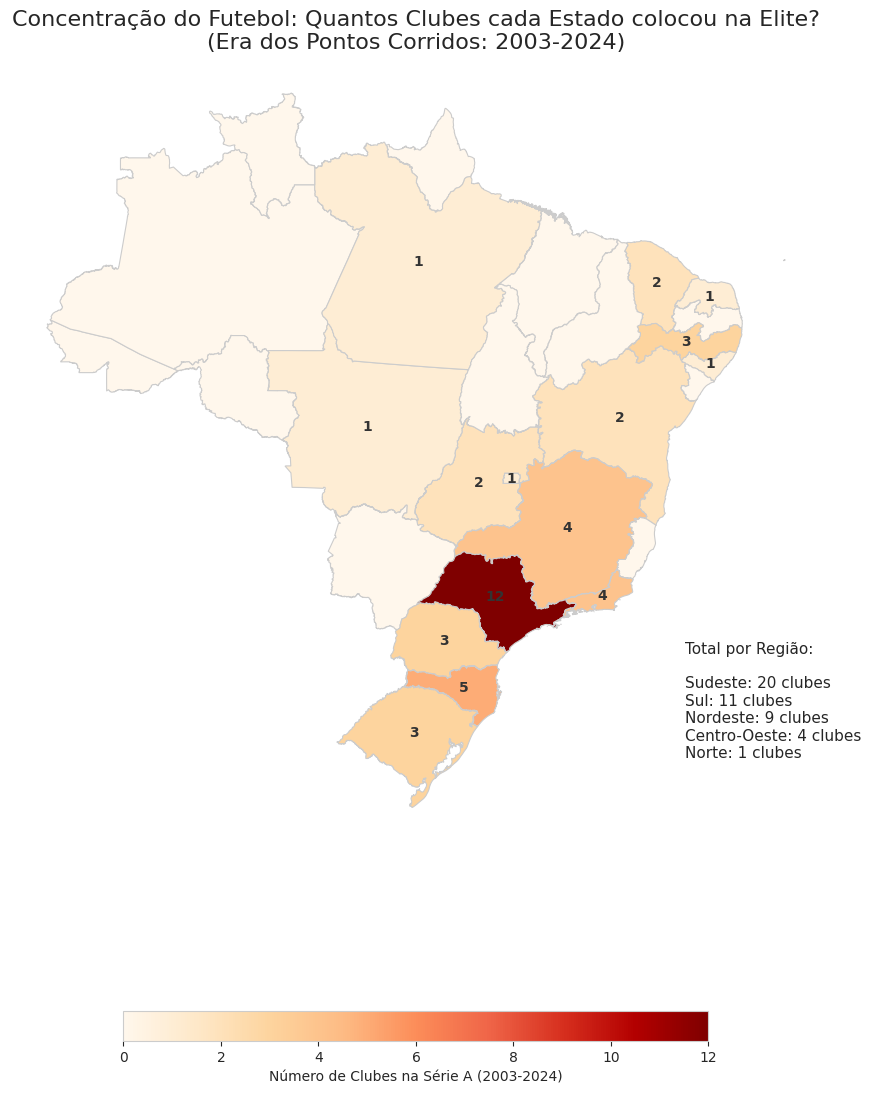

In [ ]:
# Instalar bibliotecas de mapas (se necessário)
# !pip install geopandas matplotlib mapclassify

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# 1. PREPARAÇÃO DOS DADOS
# Contar quantos times ÚNICOS cada estado teve na Série A (2003-2024)
df_uniq_teams = df_matches[['mandante', 'mandante_Estado']].drop_duplicates()
contagem_estado = df_uniq_teams['mandante_Estado'].value_counts().reset_index()
contagem_estado.columns = ['sigla', 'total_clubes']

# Mapear Regiões
regioes = {
    'Norte': ['AM', 'RR', 'AP', 'PA', 'TO', 'RO', 'AC'],
    'Nordeste': ['MA', 'PI', 'CE', 'RN', 'PB', 'PE', 'AL', 'SE', 'BA'],
    'Centro-Oeste': ['MT', 'MS', 'GO', 'DF'],
    'Sudeste': ['SP', 'RJ', 'ES', 'MG'],
    'Sul': ['PR', 'RS', 'SC']
}

def get_regiao(sigla):
    for regiao, estados in regioes.items():
        if sigla in estados: return regiao
    return 'Outro'

contagem_estado['regiao'] = contagem_estado['sigla'].apply(get_regiao)

# 2. OBTER GEOMETRIA DO BRASIL (GeoJSON)
# Usaremos um arquivo GeoJSON público confiável com os limites dos estados
url_geojson = "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson"
brasil_map = gpd.read_file(url_geojson)

# 3. MERGE (JUNTAR DADOS COM O MAPA)
# O GeoJSON tem a coluna 'sigla', nosso df tem 'sigla'.
brasil_dados = brasil_map.merge(contagem_estado, on='sigla', how='left')

# Preencher estados sem clubes (NaN) com 0
brasil_dados['total_clubes'] = brasil_dados['total_clubes'].fillna(0)

# 4. PLOTAGEM
fig, ax = plt.subplots(figsize=(12, 12))

# Desenhar o mapa
brasil_dados.plot(
    column='total_clubes',
    cmap='OrRd',      # Cor: Amarelo para Vermelho Escuro
    linewidth=0.8,
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label': "Número de Clubes na Série A (2003-2024)", 'orientation': "horizontal", 'shrink': 0.5},
    ax=ax
)

# Adicionar Rótulos (Número de Clubes em cima de cada estado)
for x, y, label in zip(brasil_dados.geometry.centroid.x, brasil_dados.geometry.centroid.y, brasil_dados['total_clubes']):
    if label > 0: # Só mostrar numero se houver clube
        ax.annotate(f'{int(label)}', xy=(x, y), xytext=(0, 0), textcoords="offset points",
                    ha='center', va='center', fontsize=10, fontweight='bold', color='#333333')

# Título e Estilo
plt.title('Concentração do Futebol: Quantos Clubes cada Estado colocou na Elite?\n(Era dos Pontos Corridos: 2003-2024)', fontsize=16)
ax.axis('off') # Remover eixos de latitude/longitude

# 5. RESUMO POR REGIÃO (Box flutuante)
resumo_regiao = contagem_estado.groupby('regiao')['total_clubes'].sum().sort_values(ascending=False)
texto_resumo = "Total por Região:\n\n"
for reg, val in resumo_regiao.items():
    texto_resumo += f"{reg}: {val} clubes\n"

plt.text(-38, -32, texto_resumo, fontsize=11, bbox=dict(facecolor='white', alpha=0.8, boxstyle='round'))

plt.tight_layout()
plt.show()